# 2.	If we define daily gain or loss of a stock is the % of change of the stock closing price to previous day closing price. Compute daily gain or loss for each S&P500 company. Do the same thing for weekly and monthly gains or losses. 

In [1]:
#importing required necessary libraries to perform analysis.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from itertools import combinations

In [2]:
#improting necessary libraries to scrape the data.
#using pool method to multiprocessing for download faster.
import requests
import urllib
from bs4 import BeautifulSoup
import re
import io
import gzip
import time
import csv
import os
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
from webdriver_manager.chrome import ChromeDriverManager
from multiprocessing import Pool
import import_ipynb
import pandas as pd
from ipynb.fs.full.scraping_daily_data import scraping_daily_data

driver = webdriver.Chrome(ChromeDriverManager().install())
url = "https://en.wikipedia.org/wiki/List_of_S%26P_500_companies"
driver.get(url)

symbols = list()
symbols_GICC = dict()

table = "/html/body/div[3]/div[3]/div[5]/div[1]/table[1]"
table = driver.find_element_by_xpath(table)
elements = table.find_elements_by_tag_name("tr")[1:]

for row in elements:
    data = [data.text for data in row.find_elements_by_tag_name("td")]
    #here i am storung all the data related to a date in a dictioanry.
    symbols.append(data[0])
    symbols_GICC[data[0]] = data[3]

print(len(symbols_GICC))



====== WebDriver manager ======
Current google-chrome version is 90.0.4430
Get LATEST driver version for 90.0.4430
Driver [C:\Users\Naveen\.wdm\drivers\chromedriver\win32\90.0.4430.24\chromedriver.exe] found in cache


505


In [3]:
#here computing daily gain or loss for each company for daily stocks, weekly an dmonthly
gain_loss_daily = pd.DataFrame(columns=["symbol","gain_loss","GICS"])
gain_loss_weekly = pd.DataFrame(columns=["symbol","gain_loss","GICS"])
gain_loss_monthly = pd.DataFrame(columns=["symbol","gain_loss","GICS"])

In [4]:

daily_dfs = {}
weekly_dfs = {}
monthly_dfs = {}


def gain_loss(sym):
    #DAILY
    #reading the csv file every file ends with daily for daily stock.
    df_daily = pd.read_csv(sym +"_daily" + ".csv")
    #here as told in question, applying formula. previous day-present closing price/present clsoing price.
    #here shit(1) means it takes the previous available value in dataframe.
    df_daily["Gain/Loss"] = (df_daily["Close"] - df_daily["Close"].shift(1)) / df_daily["Close"]
    
    #here daily gain/loss is gievn for every ticker symbol.
    daily_dfs[sym] = df_daily
    
    #WEEKLY
    df_weekly = pd.read_csv(sym +"_weekly"+".csv")
    df_weekly["Gain/Loss"] = (df_weekly["Close"] - df_weekly["Close"].shift(1)) / df_weekly["Close"]
    weekly_dfs[sym] = df_weekly
    
    #MONTHLY
    df_monthly = pd.read_csv(sym + "_monthly" + ".csv")
    df_monthly["Gain/Loss"] = (df_monthly["Close"] - df_monthly["Close"].shift(1)) / df_weekly["Close"]
    monthly_dfs[sym] = df_monthly
    
    #Here creating a dictionary to store all the gain/loss for all symbols by calling the gain_loss method.
    daily = {"symbol":sym,"gain_loss":df_daily["Gain/Loss"].sum(),"GICS":symbols_GICC[sym]}
    weekly = {"symbol":sym,"gain_loss":df_weekly["Gain/Loss"].sum(),"GICS":symbols_GICC[sym]}
    monthly = {"symbol":sym,"gain_loss":df_monthly["Gain/Loss"].sum(),"GICS":symbols_GICC[sym]}
    
    return (daily,weekly,monthly)



In [5]:
for n in symbols:
    try:
        (daily,weekly,monthly) = gain_loss(n)
        #now inserting all the method call values in dataframes created earlier.
        gain_loss_daily = gain_loss_daily.append(daily, ignore_index=True)
        #here for each df, creating an index and 3 columsn.
        gain_loss_weekly = gain_loss_weekly.append(weekly, ignore_index=True)
        gain_loss_monthly = gain_loss_monthly.append(monthly, ignore_index=True)
    except Exception as e:
        pass

In [6]:
print(gain_loss_daily)
print(gain_loss_weekly)
print(gain_loss_monthly)

Empty DataFrame
Columns: [symbol, gain_loss, GICS]
Index: []
Empty DataFrame
Columns: [symbol, gain_loss, GICS]
Index: []
Empty DataFrame
Columns: [symbol, gain_loss, GICS]
Index: []


# 3.	Top 25 gainers of S&P 500 for 1000 trading days are the companies which have max % gain during those 1000 trading days. Bottom 25 gainers of S&P 500 for 1000 trading days are the companies which have least % gain (it can be negative gain too which is loss) during those 1000 trading days. Compute and draw the correlation matrix for the top 25 and bottom 25 companies for daily gains or losses. This is a matrix with both axes holding the stock names. The color of each cell is the correlation between that pair of stocks: red for -1 and blue for 1. Do the same thing for weekly and monthly gains or losses.

In [7]:
#sorting the values as it asked for top values only.
gain_loss_daily = gain_loss_daily.sort_values(by=["gain_loss"])

#this gives us the top 25 gain values
gain_25_daily = gain_loss_daily.head(25)

#this gives bottom loss values
loss_25_daily = gain_loss_daily.tail(25)

#here ticker symbols are company names
gain_25_daily_names = list(gain_25_daily["symbol"])
loss_25_daily_names = list(loss_25_daily["symbol"])

#now for correlation matrix we need to find the combined relation by combining gain and loss names.
names = set(loss_25_daily_names+gain_25_daily_names)
samp = pd.DataFrame(columns=names,index=names)

for n1,n2 in combinations(names,2):
    df1 = daily_dfs[n1]
    df2 = daily_dfs[n2]
    samp.loc[n1,n2] = df1["Gain/Loss"].corr(df2["Gain/Loss"])
    samp.loc[n2,n1] = df2["Gain/Loss"].corr(df1["Gain/Loss"])
    samp.loc[n1,n1] = 1
    samp.loc[n2,n2] = 1
daily_samp = samp.astype({name:"float" for name in names})
daily_samp.style.background_gradient(cmap="brg")

#Correlation matrix for Weekly data

In [8]:
gain_loss_weekly = gain_loss_weekly.sort_values(by=["gain_loss"])
gain_25_daily = gain_loss_weekly.head(25)
loss_25_daily = gain_loss_weekly.tail(25)

gain_25_daily_names = list(gain_25_daily["symbol"])
loss_25_daily_names = list(loss_25_daily["symbol"])
names = set(loss_25_daily_names+gain_25_daily_names)
samp = pd.DataFrame(columns=names,index=names)
for n1,n2 in combinations(names,2):
    df1 = daily_dfs[n1]
    df2 = daily_dfs[n2]
    samp.loc[n1,n2] = df1["Gain/Loss"].corr(df2["Gain/Loss"])
    samp.loc[n2,n1] = df2["Gain/Loss"].corr(df1["Gain/Loss"])
    samp.loc[n1,n1] = 1
    samp.loc[n2,n2] = 1
weekly_samp = samp.astype({name:"float" for name in names})
weekly_samp.style.background_gradient(cmap="brg")

#Correlation matrix for monthly data

In [9]:
gain_loss_monthly = gain_loss_monthly.sort_values(by=["gain_loss"])
gain_25_daily = gain_loss_monthly.head(25)
loss_25_daily = gain_loss_monthly.tail(25)

gain_25_daily_names = list(gain_25_daily["symbol"])
loss_25_daily_names = list(loss_25_daily["symbol"])

names = set(loss_25_daily_names+gain_25_daily_names)
samp = pd.DataFrame(columns=names,index=names)
for n1,n2 in combinations(names,2):
    df1 = daily_dfs[n1]
    df2 = daily_dfs[n2]
    samp.loc[n1,n2] = df1["Gain/Loss"].corr(df2["Gain/Loss"])
    samp.loc[n2,n1] = df2["Gain/Loss"].corr(df1["Gain/Loss"])
    samp.loc[n1,n1] = 1
    samp.loc[n2,n2] = 1
monthly_samp = samp.astype({name:"float" for name in names})
monthly_samp.style.background_gradient(cmap="brg")

# 4.	For each company in top 25 and bottom 25, identify their GICS sectors from https://en.wikipedia.org/wiki/List_of_S%26P_500_companies and draw a bar graph depicting number of top 25 and bottom 25 belongs to that sector.  Do the same thing for weekly and monthly data. 

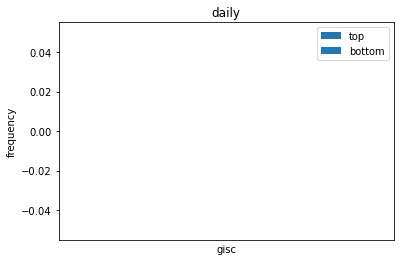

In [10]:
#here we take the top and bottom 25 values to plot the bar graph.
top_25 = dict(gain_loss_daily["GICS"].head(25).value_counts())
bottom_25 = dict(gain_loss_daily["GICS"].tail(25).value_counts())
labels = set(list(top_25.keys()) + list(bottom_25.keys()))


for lab in labels:
    if lab in top_25:
        pass
    else:
        top_25[lab] = 0
    if lab in bottom_25:
        pass
    else:
        bottom_25[lab] = 0
#here we use plt library to draw the bar graph. by giving appropriate colors.
w = 0.2
ind = np.arange(len(labels))
ind2 = [i+w for i in ind]
plt.bar(ind,top_25.values(),w,color="r",label="top")
plt.bar(ind2,bottom_25.values(),w,color="b",label="bottom")
#for x- axis we give gisc sectors
plt.xlabel("gisc")
#for y - axis we give frequency.
plt.ylabel("frequency")
plt.xticks(ind+w/2,labels,rotation=90)
plt.title("daily")
plt.legend()

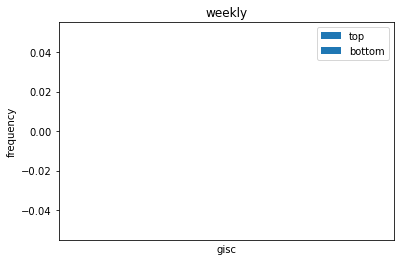

In [11]:
#here we take the top and bottom 25 values to plot the bar graph.
top_25 = dict(gain_loss_weekly["GICS"].head(25).value_counts())
bottom_25 = dict(gain_loss_weekly["GICS"].tail(25).value_counts())
labels = set(list(top_25.keys()) + list(bottom_25.keys()))


for lab in labels:
    if lab in top_25:
        pass
    else:
        top_25[lab] = 0
    if lab in bottom_25:
        pass
    else:
        bottom_25[lab] = 0
#here we use plt library to draw the bar graph. by giving appropriate colors.
w = 0.2
ind = np.arange(len(labels))
ind2 = [i+w for i in ind]
plt.bar(ind,top_25.values(),w,color="r",label="top")
plt.bar(ind2,bottom_25.values(),w,color="b",label="bottom")
#for x- axis we give gisc sectors
plt.xlabel("gisc")
#for y - axis we give frequency.
plt.ylabel("frequency")
plt.xticks(ind+w/2,labels,rotation=90)
plt.title("weekly")
plt.legend()

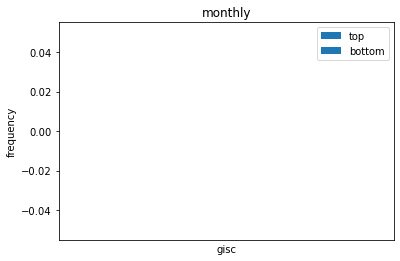

In [12]:
#here we take the top and bottom 25 values to plot the bar graph.
top_25 = dict(gain_loss_monthly["GICS"].head(25).value_counts())
bottom_25 = dict(gain_loss_monthly["GICS"].tail(25).value_counts())
labels = set(list(top_25.keys()) + list(bottom_25.keys()))


for lab in labels:
    if lab in top_25:
        pass
    else:
        top_25[lab] = 0
    if lab in bottom_25:
        pass
    else:
        bottom_25[lab] = 0
#here we use plt library to draw the bar graph. by giving appropriate colors.
w = 0.2
ind = np.arange(len(labels))
ind2 = [i+w for i in ind]
plt.bar(ind,top_25.values(),w,color="r",label="top")
plt.bar(ind2,bottom_25.values(),w,color="b",label="bottom")
#for x- axis we give gisc sectors
plt.xlabel("gisc")
#for y - axis we give frequency.
plt.ylabel("frequency")
plt.xticks(ind+w/2,labels,rotation=90)
plt.title("monthly")
plt.legend()

# 5.	For the top 2 companies, find the maximum negatively correlated companies in the remaining 48 companies from the correlation matrix.  Using Tornado templates, draw sparkline plots of the 4 companies of their daily gains or losses in the same chart. Do the same thing for weekly and monthly gains or losses. Do the same thing for bottom 2 companies. Convert these files into PDF without using a browser. 

In [13]:
import base64

#for the purpose of building a spark line graph, we have to write this spark line method.
#parameters passed are data we pass about the 2 and 48 compnaies.

def spark_line(data, figsize=(4, 0.25), **kwags):
    """
    This method will Returns a HTML image tag containing a base64 encoded sparkline style plot
    """
    data = list(data)

    fig, ax = plt.subplots(1, 1, figsize=figsize, **kwags)
    ax.plot(data)
    for k,v in ax.spines.items():
        v.set_visible(False)
    ax.set_xticks([])
    ax.set_yticks([])

    plt.plot(len(data) - 1, data[len(data) - 1], 'r.')

    ax.fill_between(range(len(data)), data, len(data)*[min(data)], alpha=0.1)
    
    #IO.bytes() will convert the web text to bytes and then embeds as an spark line image.
    img = io.BytesIO()
    plt.savefig(img, transparent=True, bbox_inches='tight')
    img.seek(0)
    plt.close()

    return base64.b64encode(img.read()).decode("UTF-8")

In [14]:
#Finding the negatively correlated companies for the top 2 companies - DAILY
top_four = list()
top_2 = gain_loss_daily.head(2)

#checking for the symbols and sorting values for each symbol.
for sym in top_2["symbol"]:
    tsym = daily_samp[sym].sort_values().index[0]
    top_four.append(sym)
    top_four.append(tsym)
    
#in this we use dropna() method to avoid the NA/NaN values in data.
all_values = list()
for num in top_four:
    val = list(daily_dfs[num]["Gain/Loss"].dropna().values)
    all_values.append(val)
    
#It opens the sparline for comparision.
with open("spark1.html", "a") as file:
        file.write('<div>Daily top</div>')
        for value in all_values:
            file.write('<div><img src="data:image/png;base64,{}"/></div>'.format(spark_line(value)))
        file.write('<div></div>')

#Doing the same above process in the bottom 2 companies.
bottom_four = list()
bottom_2 = gain_loss_daily.tail(2)
for sym in bottom_2["symbol"]:
    tsym = daily_samp[sym].sort_values().index[0]
    bottom_four.append(sym)
    bottom_four.append(tsym)
all_values = list()

for num in bottom_four:
    val = list(daily_dfs[num]["Gain/Loss"].dropna().values)
    all_values.append(val)
    
with open("spark1.html", "a") as file:
        file.write('<div>Daily bottom</div>')
        for value in all_values:
            file.write('<div><img src="data:image/png;base64,{}"/></div>'.format(spark_line(value)))
        file.write('<div></div>')

In [15]:
#Finding the negatively correlated companies for the top 2 companies - weekly
top_four = list()
top_2 = gain_loss_weekly.head(2)

#checking for the symbols and sorting values for each symbol.
for sym in top_2["symbol"]:
    tsym = weekly_samp[sym].sort_values().index[0]
    top_four.append(sym)
    top_four.append(tsym)
    
#in this we use dropna() method to avoid the NA/NaN values in data.
all_values = list()
for num in top_four:
    val = list(weekly_dfs[num]["Gain/Loss"].dropna().values)
    all_values.append(val)
    
#It opens the sparline for comparision.
with open("spark1.html", "a") as file:
        file.write('<div>Weekly top</div>')
        for value in all_values:
            file.write('<div><img src="data:image/png;base64,{}"/></div>'.format(spark_line(value)))
        file.write('<div></div>')

#Doing the same above process in the bottom 2 companies.
bottom_four = list()
bottom_2 = gain_loss_weekly.tail(2)
for sym in bottom_2["symbol"]:
    tsym = weekly_samp[sym].sort_values().index[0]
    bottom_four.append(sym)
    bottom_four.append(tsym)
all_values = list()

for num in bottom_four:
    val = list(weekly_dfs[num]["Gain/Loss"].dropna().values)
    all_values.append(val)
    
with open("spark1.html", "a") as file:
        file.write('<div>Weekly bottom</div>')
        for value in all_values:
            file.write('<div><img src="data:image/png;base64,{}"/></div>'.format(spark_line(value)))
        file.write('<div></div>')

In [16]:
#Finding the negatively correlated companies for the top 2 companies - monthly
top_four = list()
top_2 = gain_loss_monthly.head(2)

#checking for the symbols and sorting values for each symbol.
for sym in top_2["symbol"]:
    tsym = monthly_samp[sym].sort_values().index[0]
    top_four.append(sym)
    top_four.append(tsym)
    
#in this we use dropna() method to avoid the NA/NaN values in data.
all_values = list()
for num in top_four:
    val = list(monthly_dfs[num]["Gain/Loss"].dropna().values)
    all_values.append(val)
    
#It opens the sparline for comparision.
with open("spark1.html", "a") as file:
        file.write('<div>Monthly top</div>')
        for value in all_values:
            file.write('<div><img src="data:image/png;base64,{}"/></div>'.format(spark_line(value)))
        file.write('<div></div>')

#Doing the same above process in the bottom 2 companies.
bottom_four = list()
bottom_2 = gain_loss_monthly.tail(2)
for sym in bottom_2["symbol"]:
    tsym = monthly_samp[sym].sort_values().index[0]
    bottom_four.append(sym)
    bottom_four.append(tsym)
all_values = list()

for num in bottom_four:
    val = list(monthly_dfs[num]["Gain/Loss"].dropna().values)
    all_values.append(val)
    
with open("spark1.html", "a") as file:
        file.write('<div>Monthly bottom</div>')
        for value in all_values:
            file.write('<div><img src="data:image/png;base64,{}"/></div>'.format(spark_line(value)))
        file.write('<div></div>')

In [17]:
pip install pdfcrowd

  Using cached pdfcrowd-5.1.3-py2.py3-none-any.whl (39 kB)
Note: you may need to restart the kernel to use updated packages.


In [18]:
import pdfcrowd

client = pdfcrowd.HtmlToPdfClient('demo', 'ce544b6ea52a5621fb9d55f8b542d14d')
client.convertFileToFile('spark1.html', 'spark1.pdf')